# Corporación Favorita Grocery Sales Forecasting Project


# Part 1- Installation and Liberaries importation

✅ Step 0: Install Required Packages

In [3]:
#!pip install -U gdown
#!pip install statsmodels

✅ Step 1: Import Libraries

In [13]:
#  Ignore warning suggetions given by Python
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import requests
import gdown
import io

from matplotlib import pyplot as plt
import seaborn as sns

#from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
# Build the download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))

✅ Step 2: Dictionary of file IDs for clarity

In [7]:
file_ids = {
    "holiday_events": "1RMjSuqHXHTwAw_PGD5XVjhA3agaAGHDH",
    "items": "1ogMRixVhNY6XOJtIRtkRllyOyzw1nqya",
    "oil": "1Q59vk2v4WQ-Rpc9t2nqHcsZM3QWGFje_",
    "stores": "1Ei0MUXmNhmOcmrlPad8oklnFEDM95cDi",
    "train": "1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv",
    "transactions": "1PW5LnAEAiL43fI5CRDn_h6pgDG5rtBW_"
}

✅ Step 3: Load each CSV using the helper functions

In [8]:
# Load all files using the helper functions except train.csv

df_holiday_events = load_csv_from_url(make_drive_url(file_ids["holiday_events"]))
df_items          = load_csv_from_url(make_drive_url(file_ids["items"]))
df_oil            = load_csv_from_url(make_drive_url(file_ids["oil"]))
df_stores         = load_csv_from_url(make_drive_url(file_ids["stores"]))
df_transactions   = load_csv_from_url(make_drive_url(file_ids["transactions"]))
# df_train          = load_csv_from_url(make_drive_url(file_ids["train"]))

# Note: train file is very large.
# To make sure we fit RAM avaible on Google-Colab, we will load only part of the file


In [9]:
# Quick Test to Confirm
display(df_stores.head())
display(df_items.head())
display(df_holiday_events.head())
display(df_oil.head())
display(df_transactions.head())


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


What each dataframe represents:
- df_train – daily sales by store and product
- df_items – details about each item
- df_stores – store locations and types
- df_oil – oil prices (a possible external influence on sales)
- df_transactions – total store traffic per day
- df_holiday_events – national/local holidays and special events

In [10]:
# Download the train.csv file using gdown
train_url = make_drive_url(file_ids["train"])
gdown.download(train_url, "train.csv", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv
From (redirected): https://drive.google.com/uc?id=1oEX8NEJPY7wPmSJ0n7lO1JUFYyZjFBRv&confirm=t&uuid=ad27aba6-e5f7-493f-8065-4e404e8056a0
To: C:\Users\onyiu\Documents\python_code\favorita_project\train.csv
100%|█████████████████████████████████████████████████████████████████████████████| 5.00G/5.00G [12:56<00:00, 6.43MB/s]


'train.csv'

# Part 2: Exploratory Data Analysis (EDA)

 We need to filter out the data to get **only Guayas region**.

we can experiment with different chunksize values.
A chunksize of 100,000 to 1,000,000 rows is a good starting point.


In [66]:
# Select list of stores located in the 'Guayas' region
store_ids = df_stores[df_stores['state'] == 'Guayas']['store_nbr'].unique()

# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6              # Read 1 million rows at a time & Adjust based on system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('./train.csv', chunksize=chunk_size):
  chunk_filtered = chunk[chunk['store_nbr'].isin(store_ids)]  # Filter the chunk for the desired store IDs
  filtered_chunks.append(chunk_filtered)                    # Append the filtered chunk to the list

  del chunk                                                 # Delete the chunk to free up memory

# Concatenate all filtered chunks into a single DataFrame
df_train = pd.concat(filtered_chunks, ignore_index=True)      # ignore index set to TRUE, so that we don't have any problems during concatenation.



del filtered_chunks             # Delect and Clean up to free memory

In [67]:
df_train.shape

(22941656, 6)

The dataset that we have is still very big even after filtering. To prevent our work from unexpected crashes, let's limit the dataset to include only top-3 families by number of items but first let's look at this top-3:

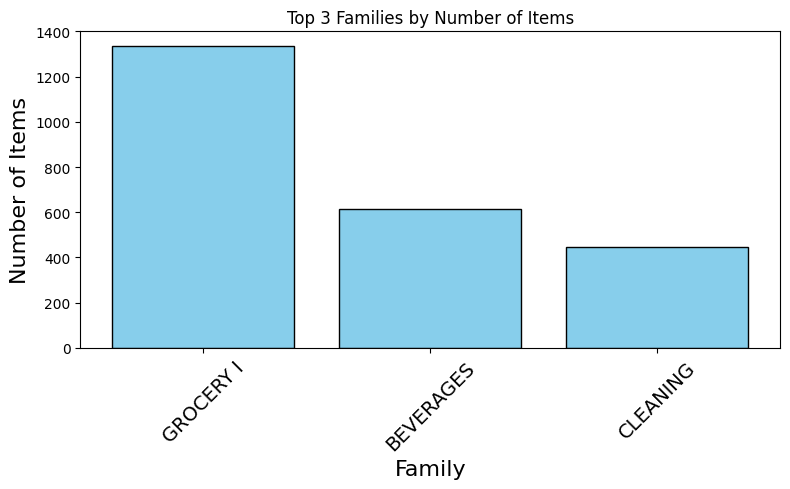

'\nwe have groceries, beverages and cleaning.\nSo these are top 3 families of items that customers normally purchase.\nthis is a part of EDA exploratory data analysis.\n'

In [68]:
# # Compute the number of items per family and select the top 3 families
items_per_family = df_items['family'].value_counts().reset_index()
items_per_family.columns = ['Family','Item Count'] # rename items_per_family
top_3_families = items_per_family.head(3) # [:3]  #  no need to do any sorting, because Value counts already returns it in descending order.

# plot the top 3 family
plt.figure(figsize = (8,5))
plt.bar(top_3_families['Family'], top_3_families['Item Count'],
        color = 'skyblue', edgecolor = 'black')
plt.title('Top 3 Families by Number of Items')
plt.xlabel("Family", fontsize=16)
plt.ylabel("Number of Items", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.tight_layout()
plt.show()

"""
we have groceries, beverages and cleaning.
So these are top 3 families of items that customers normally purchase.
this is a part of EDA exploratory data analysis.
"""

we want to filter a little further.

In [70]:
#  filtering items that only belong to groceries, beverages, and cleaning.
# And use this list of items to filter training dataset.

item_ids = df_items[df_items['family'].isin(top_3_families['Family'].unique())]['item_nbr'].unique()
df_train = df_train[df_train['item_nbr'].isin(item_ids)]          # Df train will be the DF train where df_train item number is in item_ids.


In [71]:
df_train.shape

(14745768, 6)

From around 22.9 millions of rows to around 14.7 millions. This is our reduction.

In [72]:
# Checking missing values
df_train.isnull().sum()

id                   0
date                 0
store_nbr            0
item_nbr             0
unit_sales           0
onpromotion    2747275
dtype: int64

# Part 3: Data Preprocessing or preparation

**step 3.1 Handling missing value**

In [75]:
df_train['onpromotion'].value_counts()  # check the value count

onpromotion
False    14066471
True       679297
Name: count, dtype: int64

In [76]:
# Imputate or fill them with FALSE(to most occured values)
df_train.fillna({'onpromotion': False}, inplace=True)

In [45]:
# Verify that the missing values are now handled
print("Missing values after filling 'onpromotion':")
print(df_train.isnull().sum())

Missing values after filling 'onpromotion':
id             0
date           0
store_nbr      0
item_nbr       0
unit_sales     0
onpromotion    0
dtype: int64


**Step 3.2: Check Target variable for any negative values in Unit sales and check for outliers**





check if there are negative unit sales(returned items)

In [77]:
negative_sales = df_train[df_train['unit_sales']<0]
print("Number of rows with negative sales:", len(negative_sales))
negative_sales.head()

Number of rows with negative sales: 794


,id,date,store_nbr,item_nbr,unit_sales,onpromotion
18589,106658,2013-01-04,34,586824,-2.0,False
54236,309805,2013-01-09,35,1079215,-8.0,False
64452,382905,2013-01-11,27,1097187,-20.0,False
96414,564108,2013-01-15,51,627885,-36.0,False
132903,787522,2013-01-21,24,211205,-5.0,False


**Handling negative values in Unit sales(Target)**

we basically want to justify they were not sold but were returned by replacing or transforming them with 0.

In [78]:
#df_train['unit_sales'] = df_train['unit_sales'].apply(lambda x: max(x,0))
#print(df_train.head())

**Detecting Outliers**

The Z-score method is useful for detecting extreme values that are statistically unlikely.


In [79]:
# Function to calculate Z-score for each group (store-item combination)

def calculate_store_item_zscore(group):   # defined a function calculate store item and group as my vector
  # Compute mean and standard deviation for each store-item group
  mean_sales = group['unit_sales'].mean()
  std_sales = group['unit_sales'].std()

  # Calculate Z-score (avoiding division by zero for standard deviation)
  group['z_score'] = (group['unit_sales'] - mean_sales)/(std_sales if std_sales !=0 else 1)
  return group                                 # !=0 avoid division by 0.if Std sales doesn't equal to 0, else let's set it to one.

In [80]:
# Lets group our data by store_number and item_number.
# we will calculate the Z score and apply function defined above

df_train_grouped = df_train.groupby(['store_nbr', 'item_nbr']).apply(calculate_store_item_zscore)     # this is how the group is formed
df_train_grouped.reset_index(drop=True, inplace=True)              # this will result in store and item being in the index, so I can reset them to become again the columns using (drop=True, inplace=True)

In [81]:
df_train_grouped.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'z_score'],
      dtype='object')

In [82]:
# Define threshold for outliers (e.g., Z-score > 5)
# we can define the threshold for the z-score and detect outliers:

outliers = df_train_grouped[df_train_grouped['z_score'] > 5]
outliers

# There are many of these values but they don't look like errors. These are just big sales.

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,z_score
188,15666702,2013-12-18,24,96995,14.0,False,7.946399
286,59775862,2015-10-20,24,99197,14.0,False,5.822016
289,60322807,2015-10-26,24,99197,19.0,False,8.276173
721,15717753,2013-12-19,24,103520,27.0,False,6.642670
770,18886543,2014-02-13,24,103520,22.0,False,5.154400
...,...,...,...,...,...,...,...
14741488,114286905,2017-05-01,51,2048609,48.0,False,7.830664
14742765,104195298,2017-01-25,51,2054291,21.0,False,6.141217
14743164,122354227,2017-07-16,51,2057033,21.0,True,5.247882
14743658,117045510,2017-05-27,51,2058907,12.0,False,5.054512


**Handling Outliers**

check if it is necessary later

**Step 3.4 - Handling missing Dates**

Fill missing dates for particular item-store combinations with zero(0) sales

In [83]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Get the minimum and maximum dates in the dataset to create a full date range
min_date = df_train['date'].min()
max_date = df_train['date'].max()

# Create full date range
full_date_range = pd.DataFrame({'date': pd.date_range(min_date, max_date, freq='D')})
full_date_range

,date
0,2013-01-02
1,2013-01-03
2,2013-01-04
3,2013-01-05
4,2013-01-06
...,...
1682,2017-08-11
1683,2017-08-12
1684,2017-08-13
1685,2017-08-14


Next, let's create a DataFrame with all (store, item, date) combinations

In [84]:
# # Get unique store-item pairs
store_item_combinations = df_train[['store_nbr', 'item_nbr']].drop_duplicates()

# Cartesian product: store × item × date combinations
all_combinations = store_item_combinations.merge(full_date_range, how='cross') # Use how='cross' for Cartesian product
all_combinations

,store_nbr,item_nbr,date
0,24,105574,2013-01-02
1,24,105574,2013-01-03
2,24,105574,2013-01-04
3,24,105574,2013-01-05
4,24,105574,2013-01-06
...,...,...,...
35069351,51,2123791,2017-08-11
35069352,51,2123791,2017-08-12
35069353,51,2123791,2017-08-13
35069354,51,2123791,2017-08-14


now we are finally ready to fill up the original data with missing dates by merging two dataframes

In [85]:
# Merge with original data to fill missing dates
df_filled = all_combinations.merge(df_train,
                                   on = ['store_nbr', 'item_nbr', 'date'],
                                   how ='left')
# Fill missing sales values with 0
df_filled['unit_sales'] = df_filled['unit_sales'].fillna(0)

# Check the first few rows
df_filled.head(5)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,False
1,24,105574,2013-01-03,59692.0,1.0,False
2,24,105574,2013-01-04,99664.0,3.0,False
3,24,105574,2013-01-05,140805.0,4.0,False
4,24,105574,2013-01-06,182800.0,7.0,False


Now we have all dates and corresponding sales for them. Let's replace the original dataframe

In [86]:
# Assign final df_filled version to df_train
df_train = df_filled

del df_filled    # now safe to delete

**Step 3.5. Feature Engineering**

This is a critical step to extract meaningful signals from our raw data. The goal is to enrich our df_train DataFrame with as much predictive information /features as possible that help the model understand the patterns in the sales data.

**A - Time-Based Features**

These features capture the inherent seasonality and cyclical patterns of your data.

In [89]:
# Convert date column to datetime
df_train['date'] = pd.to_datetime(df_train['date'])

# Creating new time-based features
df_train['year'] = df_train['date'].dt.year
df_train['month'] = df_train['date'].dt.month
df_train['day'] = df_train['date'].dt.day
df_train['day_of_week'] = df_train['date'].dt.dayofweek  # Monday=0, Sunday=6
df_train['is_weekend'] = df_train['day_of_week'].isin([5, 6]).astype(int)

 **B. Lag features (memory from past days)**

Useful for models like XGBoost or LSTM to learn temporal dependencies. we'll need to use groupby to create these features.

In [91]:
# Lag features (per store and item)
df_train['lag_1'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
df_train['lag_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)
df_train['lag_30'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(30)


**C. Rolling/Expanding Features**

Helps capture smoothed trends

In [92]:
# Calculating rolling average/mean of unit_sales
df_train['rolling_mean_7'] = df_train.groupby(['item_nbr', 'store_nbr'])['unit_sales'].shift(1).rolling(window=7).mean()

# Rolling statistics
df_train['rolling_std_7'] = df_train.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1).rolling(window=7).std()


In [93]:
df_train.head(10)

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,year,month,day,day_of_week,is_weekend,lag_1,lag_7,lag_30,rolling_mean_7,rolling_std_7
0,24,105574,2013-01-02,18790.0,12.0,False,2013,1,2,2,0,NaN,NaN,NaN,NaN,NaN
1,24,105574,2013-01-03,59692.0,1.0,False,2013,1,3,3,0,12.0,NaN,NaN,NaN,NaN
2,24,105574,2013-01-04,99664.0,3.0,False,2013,1,4,4,0,1.0,NaN,NaN,NaN,NaN
3,24,105574,2013-01-05,140805.0,4.0,False,2013,1,5,5,1,3.0,NaN,NaN,NaN,NaN
4,24,105574,2013-01-06,182800.0,7.0,False,2013,1,6,6,1,4.0,NaN,NaN,NaN,NaN
5,24,105574,2013-01-07,223895.0,3.0,False,2013,1,7,0,0,7.0,NaN,NaN,NaN,NaN
6,24,105574,2013-01-08,263107.0,3.0,False,2013,1,8,1,0,3.0,NaN,NaN,NaN,NaN
7,24,105574,2013-01-09,302232.0,7.0,False,2013,1,9,2,0,3.0,12.0,NaN,4.714286,3.683942
8,24,105574,2013-01-10,341031.0,3.0,False,2013,1,10,3,0,7.0,1.0,NaN,4.000000,2.236068
9,24,105574,2013-01-11,379570.0,6.0,False,2013,1,11,4,0,3.0,3.0,NaN,4.285714,1.889822


 **D. Oil Prices (external signal)**

 — Using df_oil

In [94]:
df_oil['date'] = pd.to_datetime(df_oil['date'])

# Fill forward missing oil prices
df_oil['dcoilwtico'].fillna(method='ffill', inplace=True)

# Merge into df_train
df_train = df_train.merge(df_oil, on='date', how='left')

# fill remaining NaNs (if any)
df_train['dcoilwtico'].fillna(method='bfill', inplace=True)


In [110]:
# lag and roll the oil prices basically needed for ML
df_train['dcoilwtico_lag1'] = df_train['dcoilwtico'].shift(1)

# Since oil price is an external feature, we can roll on the original column.
# But it's safer to shift it as well to avoid using the current day's data
df_train['dcoilwtico_rolling7'] = df_train['dcoilwtico'].shift(1).rolling(window=7).mean()


In [ ]:
**Merge other csv into dataframe df_traim

In [111]:
# IS_PERISHABLE (from df_items)
# =========================
df_train = df_train.merge(
    df_items[['item_nbr', 'perishable']],
    on='item_nbr',
    how='left'
)
df_train['is_perishable'] = df_train['perishable'].fillna(0).astype(int)
df_train.drop(columns=['perishable'], inplace=True)

In [105]:
#. IS_HOLIDAY (from df_holiday_events)
# =========================
df_train['date'] = pd.to_datetime(df_train['date'])
df_holiday_events['date'] = pd.to_datetime(df_holiday_events['date'])

# Create holiday flag
df_holiday_events['is_holiday'] = 1
holiday_flags = df_holiday_events[['date', 'is_holiday']].drop_duplicates()

# Merge on date
df_train = df_train.merge(holiday_flags, on='date', how='left')
df_train['is_holiday'] = df_train['is_holiday'].fillna(0).astype(int)

In [106]:
# . TRANSACTIONS INFO (from df_transactions)
# =========================
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_train = df_train.merge(df_transactions, on=['date', 'store_nbr'], how='left')
df_train['transactions'] = df_train['transactions'].fillna(0).astype(int)

In [113]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35069356 entries, 0 to 35069355
Data columns (total 22 columns):
 #   Column               Dtype         
---  ------               -----         
 0   store_nbr            int64         
 1   item_nbr             int64         
 2   date                 datetime64[ns]
 3   id                   float64       
 4   unit_sales           float64       
 5   onpromotion          object        
 6   year                 int32         
 7   month                int32         
 8   day                  int32         
 9   day_of_week          int32         
 10  is_weekend           int64         
 11  lag_1                float64       
 12  lag_7                float64       
 13  lag_30               float64       
 14  rolling_mean_7       float64       
 15  rolling_std_7        float64       
 16  dcoilwtico           float64       
 17  dcoilwtico_lag1      float64       
 18  is_perishable        int64         
 19  is_holiday         

In [114]:
df_train.to_pickle("df_train.pkl")

In [14]:
# Load df_train quickly

df_train = pd.read_pickle("df_train.pkl")


# Step 4-Visualizing Time-Series Data

- creates insightful visualizations that apply to the entire Guayas region.


**Overall Sales Trend**

A plot of the total sales over time for the entire region will reveal the macro trends and major events.

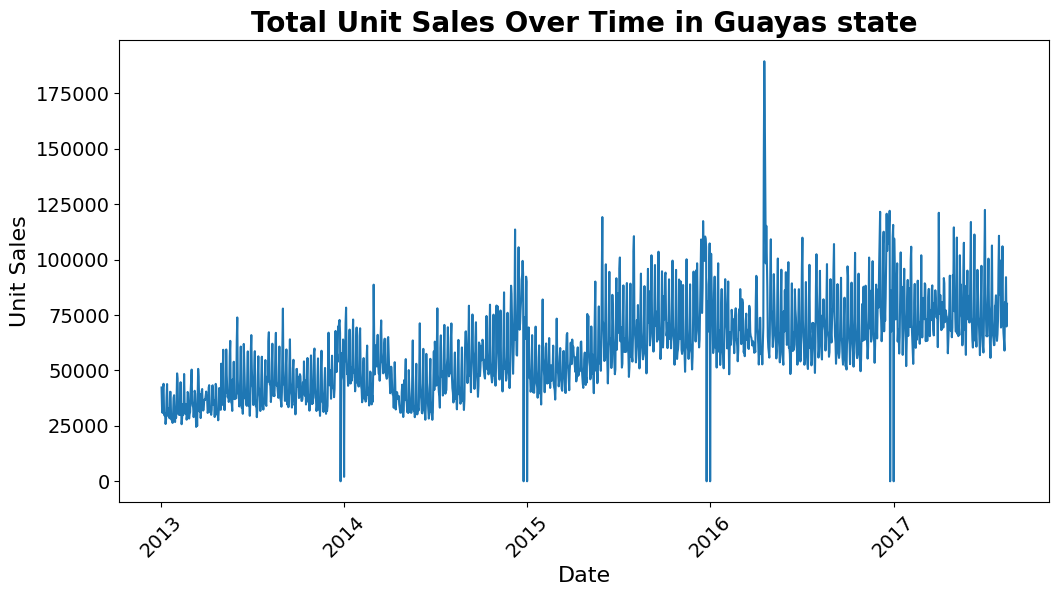

In [15]:
# Aggregating total sales by date
sales_by_date = df_train.groupby('date')['unit_sales'].sum()

# Plotting the time-series
plt.figure(figsize=(12,6))
plt.plot(sales_by_date.index, sales_by_date.values)
plt.title('Total Unit Sales Over Time in Guayas state', fontsize=20, fontweight='bold')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Unit Sales', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

**monthly Seasonal Heatmap**

A heatmap is an excellent way to visualize monthly sales patterns for the entire region.

Text(0.5, 1.0, 'Monthly Sales Trends Over Years')

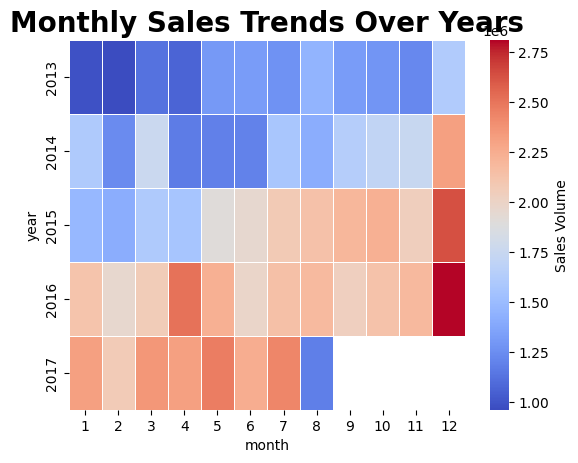

In [16]:
# Aggregating sales by year and month
# .unstack(): reshapes the table so that: Each row is a year, Each column is a month (1–12), The values are total sales.

sales_by_month = df_train.groupby(['year', 'month'])['unit_sales'].sum().unstack()

#  Plotting heatmap of sales by year and month
sns.heatmap(
           sales_by_month, 
           cmap='coolwarm',                    # Use a diverging colormap for better contrast
           linewidths=0.5,                     # Add lines between cells for clarity
           linecolor='white',                  # Use white lines for a cleaner look
           cbar_kws={'label': 'Sales Volume'}  # Add a descriptive colorbar label
)


plt.title('Monthly Sales Trends Over Years', fontsize=20, fontweight='bold')


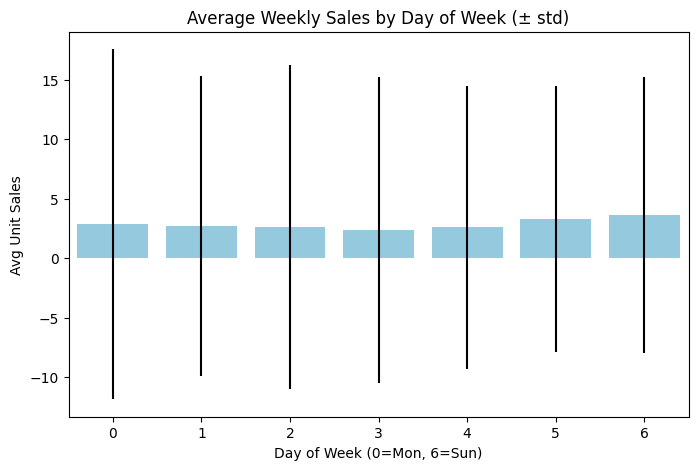

In [17]:
# Weekly Seasonality → Bar Plot (mean sales by day of week with error)
weekly = df_train.groupby("day_of_week")["unit_sales"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=weekly, x="day_of_week", y="mean", yerr=weekly["std"], color="skyblue")
plt.title("Average Weekly Sales by Day of Week (± std)")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Avg Unit Sales")
plt.show()

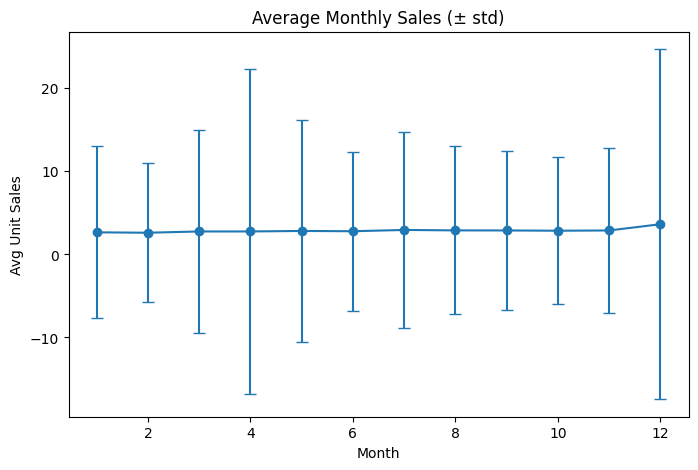

In [18]:
# . Monthly Seasonality → Line Plot (trend across months + error bar)

monthly = df_train.groupby("month")["unit_sales"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(8,5))
plt.errorbar(monthly["month"], monthly["mean"], yerr=monthly["std"], fmt='-o', capsize=4)
plt.title("Average Monthly Sales (± std)")
plt.xlabel("Month")
plt.ylabel("Avg Unit Sales")
plt.show()


### **Step 5: Examining the Impact of Holidays on sales**

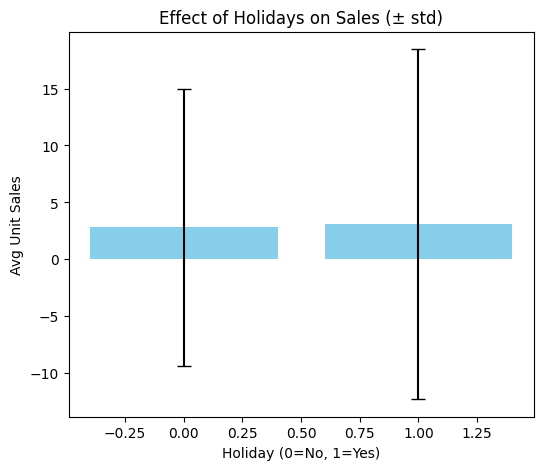

In [19]:
holiday = df_train.groupby("is_holiday")["unit_sales"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(6,5))
plt.bar(holiday['is_holiday'], holiday['mean'], yerr=holiday['std'], capsize=5, color='skyblue')
plt.title("Effect of Holidays on Sales (± std)")
plt.xlabel("Holiday (0=No, 1=Yes)")
plt.ylabel("Avg Unit Sales")
plt.show()


### Step 6: Analyzing Perishable Items  

In [20]:
# Perishables vs Non-Perishables → Bar Plot

if "perishable" in df_train.columns:
    perish = df_train.groupby("perishable")["unit_sales"].mean().reset_index()

    plt.figure(figsize=(6,5))
    sns.barplot(data=perish, x="perishable", y="unit_sales", palette="muted")
    plt.title("Perishable vs Non-Perishable Sales")
    plt.xlabel("Perishable (0=No, 1=Yes)")
    plt.ylabel("Avg Unit Sales")
    plt.show()
            

In [ ]:
### Step 7: Promotions Impact 

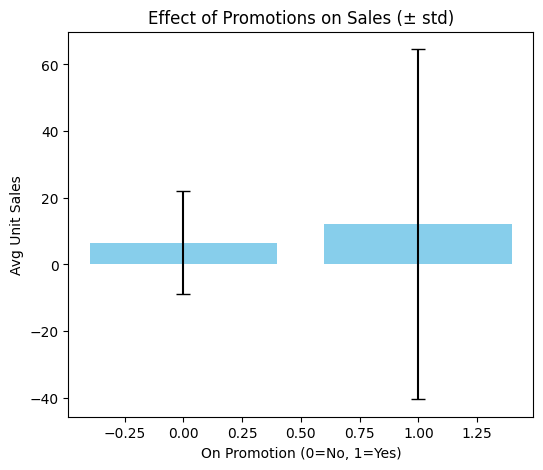

In [21]:
promo = df_train.groupby("onpromotion")["unit_sales"].agg(["mean", "std"]).reset_index()

plt.figure(figsize=(6,5))
plt.bar(promo['onpromotion'], promo['mean'], yerr=promo['std'], capsize=5, color='skyblue')
plt.title("Effect of Promotions on Sales (± std)")
plt.xlabel("On Promotion (0=No, 1=Yes)")
plt.ylabel("Avg Unit Sales")
plt.show()



Oil Prices vs Sales- Does sales volume go up/down when oil prices rise?

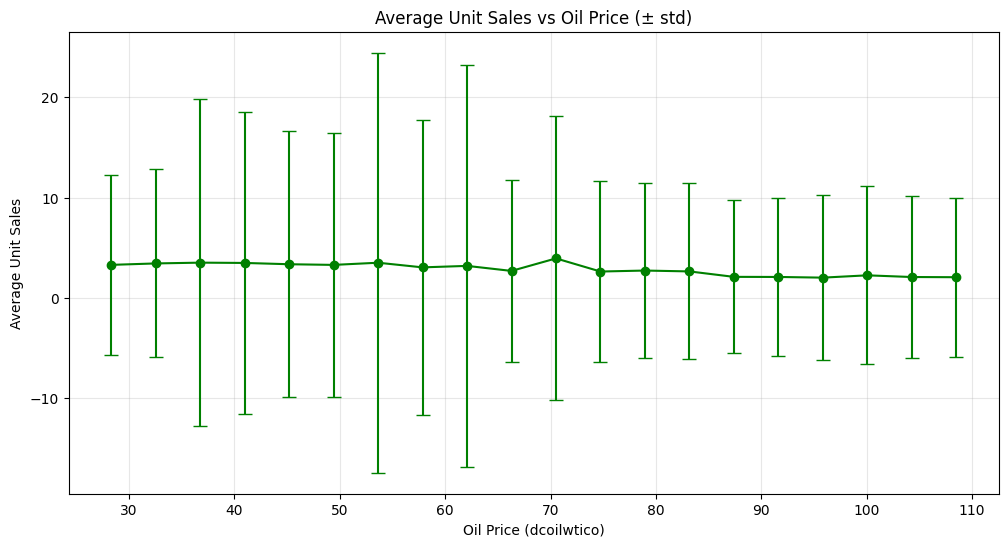

In [22]:
# Create 20 bins of oil prices
df_train['oil_bin'] = pd.cut(df_train['dcoilwtico'], bins=20)

# . Aggregate mean & std of sales per bin
oil_sales = df_train.groupby('oil_bin')['unit_sales'].agg(['mean', 'std']).reset_index()
# Use the midpoint of each bin for plotting
oil_sales['oil_mid'] = oil_sales['oil_bin'].apply(lambda x: x.mid)

# Plot mean ± std with error bars
plt.figure(figsize=(12,6))
plt.errorbar(oil_sales['oil_mid'], oil_sales['mean'], yerr=oil_sales['std'], fmt='o-', capsize=5, color='green')
plt.title("Average Unit Sales vs Oil Price (± std)")
plt.xlabel("Oil Price (dcoilwtico)")
plt.ylabel("Average Unit Sales")
plt.grid(alpha=0.3)
plt.show()


In [23]:
# compute correlation:
df_train[['unit_sales', 'dcoilwtico']].corr()

,unit_sales,dcoilwtico
unit_sales,1.000000,-0.047279
dcoilwtico,-0.047279,1.000000


This means there's a moderate negative correlation between oil prices (dcoilwtico) and unit sales